<a href="https://colab.research.google.com/github/feniltailor22/Machine_Learning-and-Deep_Learning/blob/main/Semantic_Segmentation_of_Nuclei_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf

In [2]:
from tqdm import tqdm #used to show progress bar
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
img= cv2.imread('/content/drive/MyDrive/Semantic Segmentation using UNet/UNet Architecture.png')

Text(0.5, 1.0, 'UNet Architecture')

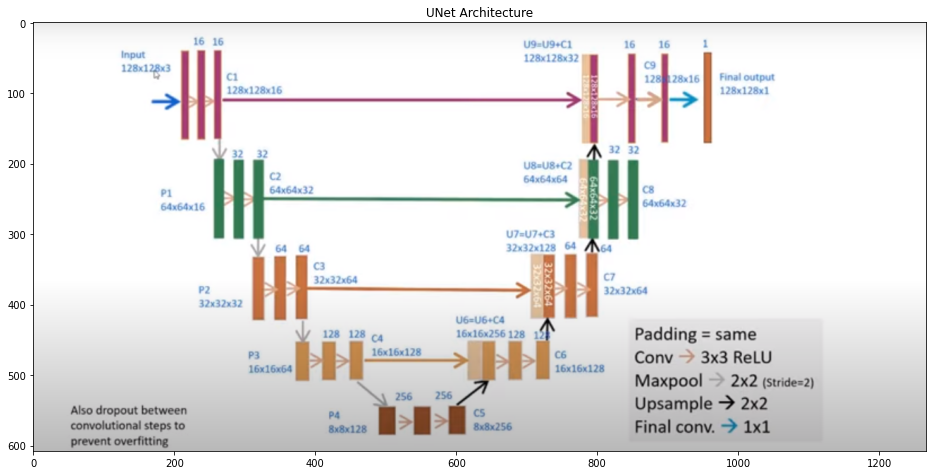

In [4]:
plt.figure(figsize = (16,20))
plt.imshow(img)
plt.title('UNet Architecture')

In [5]:
img_width= 128
img_height= 128
img_channels= 3

In [6]:
TRAIN_PATH = '/content/drive/MyDrive/Semantic Segmentation using UNet/Train/'
TEST_PATH = '/content/drive/MyDrive/Semantic Segmentation using UNet/Test/'

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
train_ids[0]

'3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90'

In [9]:
test_ids[0]

'fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f'

In [10]:
#Creating empty arrays which have same dimensions as input images
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

In [11]:
X_train.shape

(67, 128, 128, 3)

In [12]:
Y_train.shape

(67, 128, 128, 1)

In [13]:
single_image= X_train[0]

In [14]:
single_image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

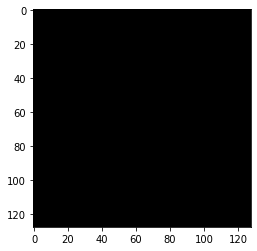

In [15]:
plt.imshow(single_image)

In [16]:
single_image.shape

(128, 128, 3)

In [17]:
Y_train[0]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [18]:
#Resizing training images and masks

In [19]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

100%|██████████| 67/67 [08:55<00:00,  8.00s/it]


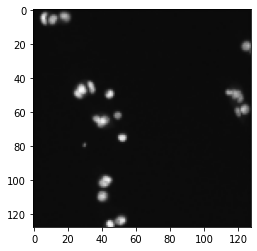

In [20]:
plt.imshow(single_image)  #single_image after resizing and masking

In [21]:
single_image.shape

(128, 128, 3)

In [22]:
# test images
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []

In [23]:
test_image= X_test[0]

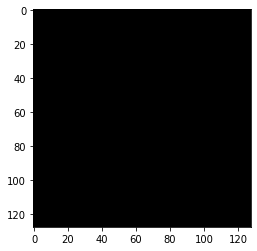

In [24]:
plt.imshow(test_image)

In [25]:
test_image.shape

(128, 128, 3)

In [26]:
#Resizing test images

In [27]:
 for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 35/35 [00:13<00:00,  2.63it/s]


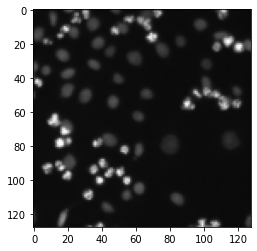

In [28]:
plt.imshow(test_image) #test_image after resizing and masking

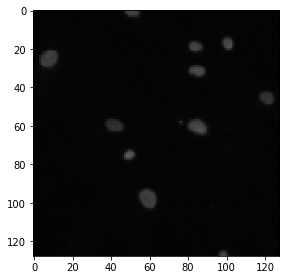

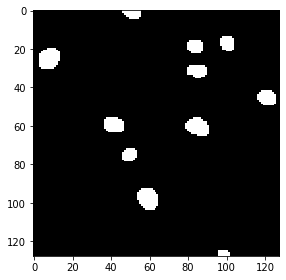

In [29]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [30]:
#Building the model

In [31]:
inputs= tf.keras.layers.Input(shape=(img_width, img_height, img_channels)) #Input Layer
std_inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs) #standardizing the input image

In [32]:
#Contraction Path (Encoder)

In [33]:
c1= tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(std_inputs) #Conv-1.1
c1= tf.keras.layers.Dropout(rate=0.1)(c1) #Dropout
c1= tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) #Conv-1.2
p1= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1) #MaxPooling

In [34]:
c2= tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1) #Conv-2.1
c2= tf.keras.layers.Dropout(rate=0.1)(c2) #Dropout
c2= tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2) #Conv-2.2
p2= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2) #MaxPooling

In [35]:
c3= tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2) #Conv-3.1
c3= tf.keras.layers.Dropout(rate=0.2)(c3) #Dropout
c3= tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3) #Conv-3.2
p3= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3) #MaxPooling

In [36]:
c4= tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3) #Conv-4.1
c4= tf.keras.layers.Dropout(rate=0.2)(c4) #Dropout
c4= tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4) #Conv-4.2
p4= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4) #MaxPooling

In [37]:
c5= tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4) #Conv-5.1
c5= tf.keras.layers.Dropout(rate=0.3)(c5) #Dropout
c5= tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5) #Conv-5.2
p5= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c5) #MaxPooling

In [38]:
#Expansive path (Decoder)

In [39]:
u6 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(c5) #ConvT-6.1
u6 = tf.keras.layers.concatenate([u6, c4]) #u6+c4
c6 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6) #Conv-6.2
c6 = tf.keras.layers.Dropout(0.2)(c6) #Dropout
c6 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6) #Conv-6.3

In [40]:
u7 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(c6) #ConvT-7.1
u7 = tf.keras.layers.concatenate([u7, c3]) #u7+c3
c7 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7) #Conv-7.2
c7 = tf.keras.layers.Dropout(0.2)(c7) #Dropout
c7 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7) #Conv-7.3

In [41]:
u8 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(c7) #ConvT-8.1
u8 = tf.keras.layers.concatenate([u8, c2]) #u8+c2
c8 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8) #Conv-8.2
c8 = tf.keras.layers.Dropout(0.1)(c8) #Dropout
c8 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8) #Conv-8.3

In [42]:
u9 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(c8) #ConvT-9.1
u9 = tf.keras.layers.concatenate([u9, c1]) #u9+c1
c9 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9) #Conv-9.2
c9 = tf.keras.layers.Dropout(0.1)(c9) #Dropout
c9 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9) #Conv-9.3

In [43]:
outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(c9) #Output Layer

In [44]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [45]:
#Modelcheckpoint

In [46]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer
        ]

In [47]:
results= model.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=50,
    verbose=True,
    callbacks=callbacks,
    validation_split=0.1
)

Epoch 1/50
4/4 [==============================] - 13s 3s/step - loss: 0.6940 - accuracy: 0.6022 - val_loss: 0.6769 - val_accuracy: 0.7785
Epoch 2/50
4/4 [==============================] - 10s 3s/step - loss: 0.6606 - accuracy: 0.8010 - val_loss: 0.6671 - val_accuracy: 0.7791
Epoch 3/50
4/4 [==============================] - 10s 2s/step - loss: 0.6221 - accuracy: 0.8046 - val_loss: 0.6391 - val_accuracy: 0.7791
Epoch 4/50
4/4 [==============================] - 10s 3s/step - loss: 0.6101 - accuracy: 0.8071 - val_loss: 0.6213 - val_accuracy: 0.7791
Epoch 5/50
4/4 [==============================] - 12s 3s/step - loss: 0.6107 - accuracy: 0.8072 - val_loss: 0.6069 - val_accuracy: 0.7791
Epoch 6/50
4/4 [==============================] - 10s 3s/step - loss: 0.5813 - accuracy: 0.8072 - val_loss: 0.5940 - val_accuracy: 0.7791
Epoch 7/50
4/4 [==============================] - 10s 3s/step - loss: 0.5518 - accuracy: 0.8072 - val_loss: 0.5432 - val_accuracy: 0.7791
Epoch 8/50
4/4 [==================

In [48]:
idx = random.randint(0, len(X_train))

In [49]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

2/2 [==============================] - 1s 129ms/step


In [ ]:
#Each pixel is given a value between 0 and 1. We set a threshoud 0.5 to binarize.
#Threshold prediction to binarize the image. 

In [50]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [51]:
# Perform a sanity check on some random training samples

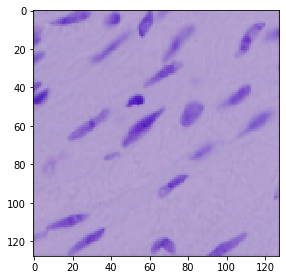

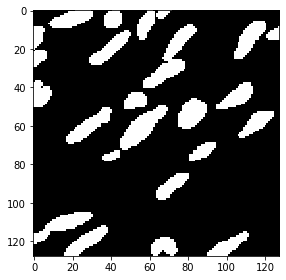

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


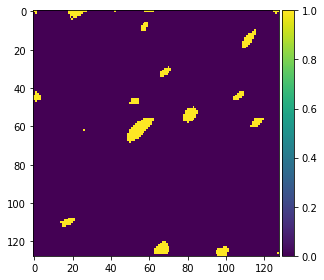

In [52]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [53]:
# Perform a sanity check on some random validation samples

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


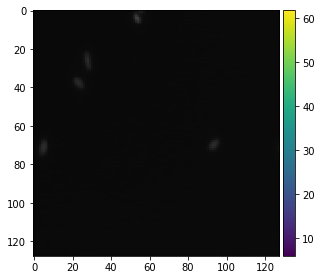

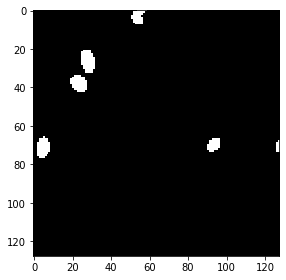

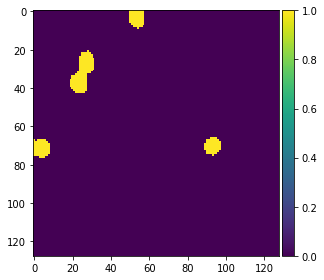

In [54]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [55]:
int(X_train.shape[0]*0.9)

60